# Определение стоимости автомобилей

## Описание проекта

### Цель проекта

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

### Исходные данные

Компания-заказчик предоставила файл `autos.csv` со следующими данными:

**Признаки**
- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `Repaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

**Целевой признак**
- `Price` — цена (евро)

### Этапы проекта

Решать поставленную задачу будем в следующем порядке:
1. Загрузим данные, путь к файлу: `/datasets/autos.csv`.
2. Изучим данные. О качестве данных ничего неизвестно. В случае обнаружения аномалий и несоответствий проведем предобработку данных.
3. Подготовим выборки для обучения моделей.
4. Обучим разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуем разные гиперпараметры.
5. Проанализируем время обучения, время предсказания и качество моделей.
6. Опираясь на критерии заказчика, выберем лучшую модель, проверим её качество на тестовой выборке.

Таким образом проект пройдет в следующие этапы:

- Обзор данных.
- Предобработка данных.
- Исследовательский анализ данных.
- Подготовка данных.
- Обучение моделей.
- Анализ скорости и качества моделей.
- Общий вывод.

## Загрузка данных

### Подготовка библиотек и загрузка данных

In [1]:
# библиотеки и обновления, установленные на сервере самостоятельно, слетают, поэтому ячейка всегда активна.
!pip install -U scikit-learn
!pip install phik
!pip install missingno


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
## импортируем необходимые библиотеки----------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import missingno as msno
import warnings
import lightgbm as lgb
import datetime

## из библиотек импортируем необходимые функции и классы---------------------------------
from scipy import stats as st
from matplotlib.pyplot import figure
from math import factorial, sqrt

# загружаем функции
from sklearn.model_selection import train_test_split
from scipy.stats import binom, norm
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from pandas.plotting import scatter_matrix
from time import time

# загружаем инструменты для автоподбора гиперпараметров
from sklearn.model_selection import (
    RandomizedSearchCV,
    GridSearchCV
)
# загружаем классы моделей
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.svm import SVR
from lightgbm import LGBMRegressor

# загружаем класс для работы с пайплайнами
from sklearn.pipeline import Pipeline

# загружаем метрики
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error, 
    r2_score,
    accuracy_score,
    confusion_matrix,
    recall_score, 
    precision_score,
    roc_auc_score,
    make_scorer # создание пользовательской метрики
)

# загружаем классы для преобразования данных
from sklearn.preprocessing import (
    OneHotEncoder, 
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler, 
    RobustScaler,
    LabelEncoder
)    
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

## константы----------------------------------------------------------------------------

# константа для фиксации данных при обучении моделей, чтобы получать одинаковые результаты при пересчёте
RANDOM_STATE = 42  

# размер тестовой выборки
TEST_SIZE = 0.25   

## скрываем предупреждения--------------------------------------------------------------

warnings.filterwarnings('ignore')
np.warnings = warnings

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Библиотеки импортировали - отлично!

Cоздадим датафрейм `df` из файла `autos.csv`.

In [3]:
# загружаем данные заказчика
df = pd.read_csv('autos.csv')

- Данные загружены в датафрейм.
- Ошибок не обнаружено.

### Получение общей информации о данных

Выведем первые строки созданного датафрейма и общую информацию.

In [4]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

**Вывод:** 
- в ряде столбцов имеются пропуски:
  - `VehicleType`;
  - `Gearbox`;
  - `Model`;
  - `FuelType`;
  - `Repaired`.
  
- столбцы `DateCrawled`, `DateCreated`, `LastSeen` предполагают тип даты (datetime64), но представлены строкой.

- названия всех столбцов написаны в разных регистрах без разделения слов, для удобства лучше привести их к "змеинному" регистру.

- столбец `Repaired` предполагает булев тип, но для нашей модели оставим тип данных без изменений.

## Предобработка данных

### Удаление столбцов

Исключим из рассмотрения следующие признаки:
- `DateCrawled`: анкета из базы может быть скачана в любой момент, эту информацию не будем учитывать при построении модели.
- `DateCreated`: аналогично предыдущему пункту.
- `NumberOfPictures`: наличие или отсутствие фотографий не характеризует сам автомобиль и не может учитываться для определения стоимости автомобиля.
- `PostalCode`: почтовый индекс владельца в теории может влиять на цену авто, поскольку почтовый индекс привязан к определенной территории - стране, городу. В разных странах один и тот же автомобииль может стоить по-разному. Однако, если вводить такой параметр, как местоположение, то следует подготовить более явные признаки: "страна", "город" и т.п. В текущем виде признак `postal_code` не подходит.
- `LastSeen`: дата последней пользовательской активности не может определять стоимость автомобиля.
- `RegistrationMonth`: месяц регистрации автомобиля не является важным признаком.


Поскольку перечисленные признаки не будем учитывать при построении модели и оценивать в ходе исследовательского анализа, удалим их из датафрейма.

In [6]:
# Сохраним столбец `DateCrawled`, как отдельный вспомогательный объект
# pandas. Данные этого столбца будут нужны при обработке аномалий.
date_crawled = df['DateCrawled'].astype('datetime64')

In [7]:
# удаляем ненужные столбцы из датафрейма
df = df.drop(columns=['DateCrawled', 
                      'DateCreated', 
                      'NumberOfPictures',
                      'PostalCode',
                      'LastSeen',
                      'RegistrationMonth'])

In [8]:
# выведем общую информацию о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       316879 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           334536 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             334664 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   FuelType          321474 non-null  object
 8   Brand             354369 non-null  object
 9   Repaired          283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


**Вывод:**

- Столбцы (признаки) успешно удалены, ошибок не обнаружено.

### Изменение названий столбцов

Приведем названия столбцов в датафрейме `df` к "змеинному" регистру и сократим их длину.

In [9]:
# переименуем столбцы в датафрейме
df = df.rename(
    columns={
        'Price':            'price',              
        'VehicleType':      'vehicle_type',
        'RegistrationYear': 'reg_year',
        'Gearbox':          'gearbox',
        'Power':            'power',
        'Model':            'model',
        'Kilometer':        'kilometer',
        'FuelType':         'fuel_type',
        'Brand':            'brand',
        'Repaired':         'repaired'
    }
)

In [10]:
# выведем названия столбцов после изменения
df.columns

Index(['price', 'vehicle_type', 'reg_year', 'gearbox', 'power', 'model',
       'kilometer', 'fuel_type', 'brand', 'repaired'],
      dtype='object')

**Вывод:**

Столбцы успешно переименованы.

### Проверка на дубликаты

Проверим данные на наличие явных дубликатов. Проверка на неявные дубликаты не требуется.

**Проверка на явные дубликаты.**

In [11]:
print('Количество дубликатов:', df.duplicated().sum())

Количество дубликатов: 45040


Обнаружены явные дубликаты, удалим их.

In [12]:
df = df.drop_duplicates().reset_index(drop=True)

In [13]:
# выведем размер датафрейма
df.shape

(309329, 10)

**Проверка на неявные дубликаты.**

Проверим на неявные дубликаты следующие столбцы:
- `brand` - марка автомобиля;
- `model` - марка автомобиля;
- `fuel_type` - тип топлива;
- `vehicle_type` - тип кузова.

In [14]:
# выведем уникальные значения столбца `brand`
df['brand'].value_counts().sort_index()

alfa_romeo         2142
audi              25470
bmw               31716
chevrolet          1648
chrysler           1352
citroen            4798
dacia               830
daewoo              508
daihatsu            752
fiat               8675
ford              22400
honda              2637
hyundai            3295
jaguar              479
jeep                639
kia                2247
lada                210
lancia              443
land_rover          507
mazda              5113
mercedes_benz     28696
mini               2866
mitsubishi         2812
nissan             4489
opel              33957
peugeot            9808
porsche             699
renault           15798
rover               449
saab                484
seat               6188
skoda              4967
smart              4823
sonstige_autos     2931
subaru              726
suzuki             2158
toyota             4248
trabant             555
volkswagen        63907
volvo              2907
Name: brand, dtype: int64

**В столбце `brand` неявных дубликатов не обнаружено.**

In [15]:
# посчитаем уникальные значения столбца `model`
df['model'].nunique()

250

In [16]:
# Сброс ограничений на количество выводимых рядов
pd.set_option('display.max_rows', 300)

In [17]:
# выведем уникальные значения столбца `model`
df['model'].value_counts().sort_index()

100                     379
145                      48
147                     525
156                     572
159                     197
1_reihe                1159
1er                    3064
200                      17
2_reihe                4174
300c                    134
3_reihe                3127
3er                   16700
4_reihe                 567
500                     828
5_reihe                 406
5er                    6677
601                     394
6_reihe                1162
6er                     147
7er                     894
80                     1413
850                     195
90                       99
900                     107
9000                     28
911                      77
a1                      530
a2                      328
a3                     5238
a4                     8268
a5                      473
a6                     4844
a8                      484
a_klasse               3789
accord                  326
agila               

In [18]:
# заменяем обнаруженные неявные дубликаты
df['model'] = (df['model']
    .replace('rangerover', 'range_rover', regex=True))

# посчитаем уникальные значения столбца `model`
df['model'].nunique()

249

В столбце `model` обнаружено значительное число вхождений значения `"other"`.

In [19]:
# выведем число "other" в столбце
df['model'].str.count("other").sum()

22934.0

In [20]:
# Заменим значение "other" на NaN для дальнейшей обработки в пайплайне
df['model'] = df['model'].replace('other', np.nan)

# посчитаем уникальные значения столбца `model`
df['model'].nunique()

248

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309329 entries, 0 to 309328
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   price         309329 non-null  int64 
 1   vehicle_type  274770 non-null  object
 2   reg_year      309329 non-null  int64 
 3   gearbox       292122 non-null  object
 4   power         309329 non-null  int64 
 5   model         268034 non-null  object
 6   kilometer     309329 non-null  int64 
 7   fuel_type     278565 non-null  object
 8   brand         309329 non-null  object
 9   repaired      244771 non-null  object
dtypes: int64(4), object(6)
memory usage: 23.6+ MB


**Обработка дубликатов и значений `"other"` в столбце `model` прошла корректно.**

In [22]:
# посчитаем уникальные значения столбца `fuel_type`
df['fuel_type'].nunique()

7

In [23]:
# выведем уникальные значения столбца
df['fuel_type'].value_counts()

petrol      187848
gasoline     84794
lpg           4888
cng            524
hybrid         222
other          200
electric        89
Name: fuel_type, dtype: int64

In [24]:
# заменяем обнаруженные неявные дубликаты
df['fuel_type'] = df['fuel_type'].replace({'gasoline':'petrol',
                                           'cng':'gas',
                                           'lpg':'gas'})
# выведем уникальные значения столбца
df['fuel_type'].value_counts()

petrol      272642
gas           5412
hybrid         222
other          200
electric        89
Name: fuel_type, dtype: int64

**Неявные дубликаты в столбце `fuel_type` обработаны.**

In [25]:
# посчитаем уникальные значения столбца `vehicle_type`
df['vehicle_type'].nunique()

8

In [26]:
# выведем уникальные значения столбца
df['vehicle_type'].value_counts()

sedan          78206
small          67548
wagon          56367
bus            25830
convertible    18195
coupe          14690
suv            10776
other           3158
Name: vehicle_type, dtype: int64

**Неявные дубликаты в столбце `vehicle_type` не обнаружены.**

**Вывод:**

Дубликаты удалены. 

## Исследовательский анализ данных

Изучим признаки и проверим их на наличие аномалий.

In [27]:
# функция для построения гистограммы, боксплота и вывода описательных статистик
def plot_hist_boxplot(df, column, title, xlabel, bins = [50, 50]):

    np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

    fig, axes = plt.subplots(2, 1, figsize=(15, 10))

    axes[0].hist(df[column], bins = bins[0], alpha = 1)
    axes[0].grid()
    plt.xlabel(xlabel)

    df.boxplot(column, ax = axes[1], vert = False)
    fig.suptitle(title)

    plt.show()
    
    # выведем основные описательные статистики
    print(df[column].describe())

Создадим функцию `barh` для для построения горизонтальных столбчатых диаграмм.

In [28]:
## строим диаграмму, подписываем и расставляем значения столбцов
def barh(data, size_x, size_y, title, xlabel, ylabel, legend_loc=0):
    ax = data.plot(kind='barh') 
    
    # функция для подписывания столбцов, передаем сумму длин прямоугольников 
    # для подсчета процентного соотношения
    def annotate(sum_width):
        ax.annotate(
                (f'{p.get_width()} ({(p.get_width()/sum_width*100).round(1)}%)'), 
                (p.get_x() + p.get_width() + max_* 0.02 , p.get_y() + p.get_height() * 0.5), 
                ha='left', 
                va='center', 
                color='black');
    
    # считаем длины прямоугольников, суммируем половину для подсчета процентного соотношения
    # ищем максимальную длину для автоматического масштабирования графиков
    sum_width, max_ = 0, 0
    
    for i in ax.patches:
        width = i.get_width()
        sum_width += width  
        if width > max_:
            max_ = width
            
    # подписываем значения столбцов и рассчитываем процентное соотношение       
    for p in ax.patches:
            annotate(sum_width=sum_width)
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    # положение легенды, если задано
    if legend_loc:    
        plt.legend(loc=legend_loc)
    
    plt.margins(0.3)          # увеличиваем расстояние до края
    fig = plt.gcf()           # увеличиваем размеры графика
    fig.set_size_inches(size_x, size_y)  # увеличиваем размеры графика
    
    plt.show()

### Тип автомобильного кузова

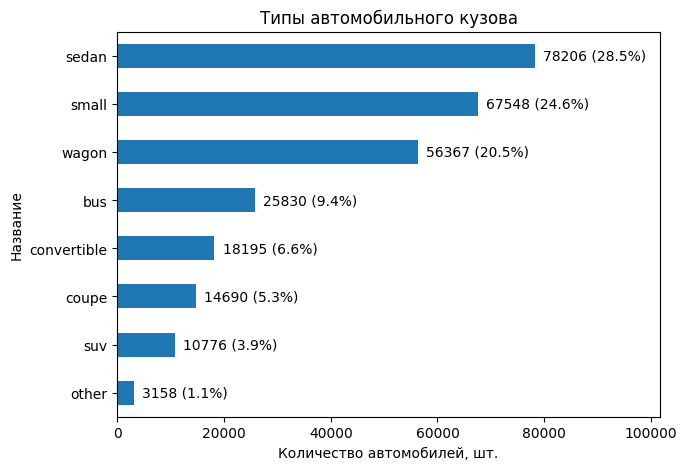

In [29]:
data = df['vehicle_type'].value_counts().sort_values()
df_vehicle_type = barh(data=data, size_x=7, size_y=5,
          title="Типы автомобильного кузова",
          xlabel="Количество автомобилей, шт.",
          ylabel="Название")

**Вывод:**

- Седаны составляют наибольшую долю.

### Год регистрации автомобиля

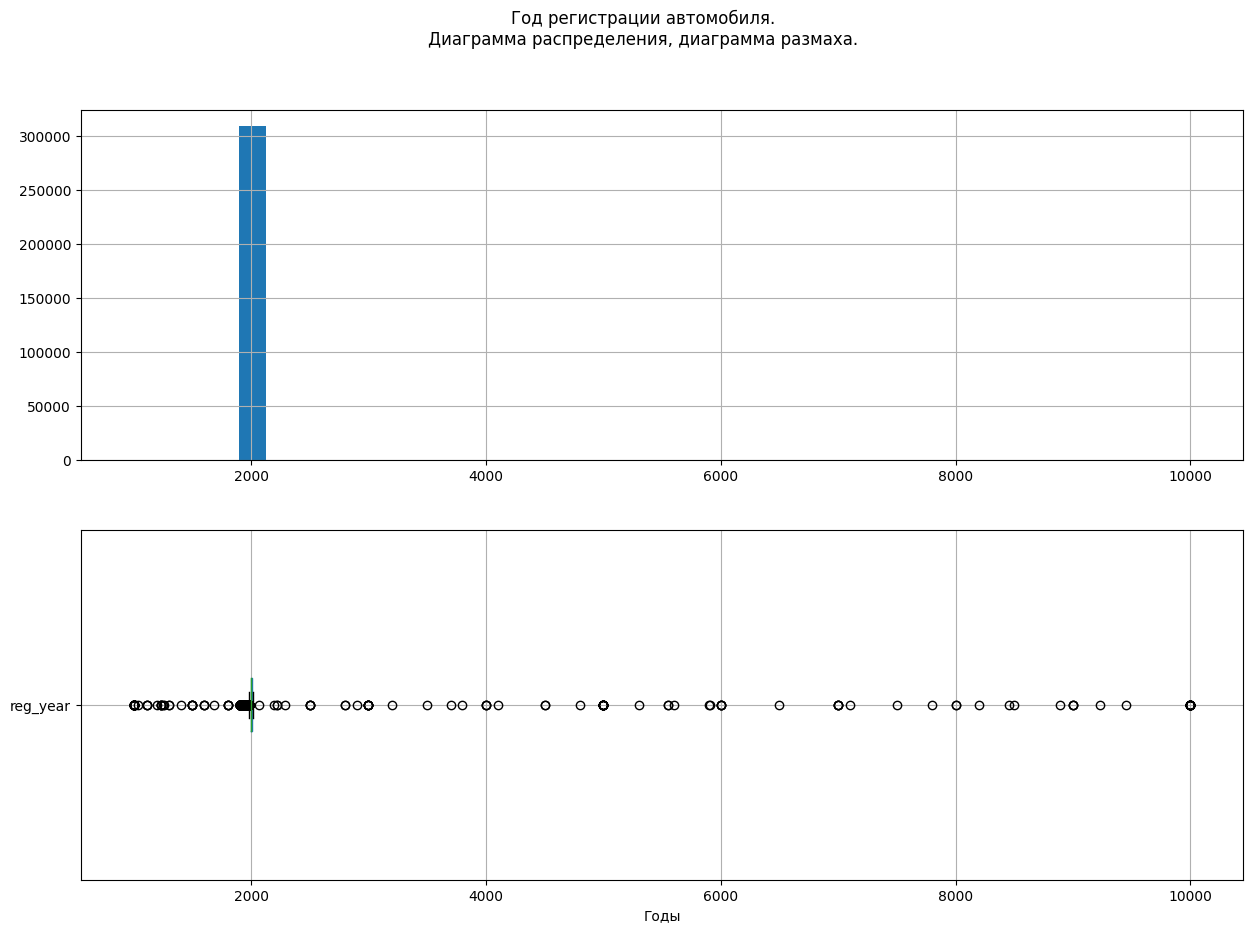

count    309329.000000
mean       2004.360105
std          92.541399
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: reg_year, dtype: float64


In [30]:
plot_hist_boxplot(df=df, 
                  column='reg_year',
                  title='Год регистрации автомобиля.\n\
Диаграмма распределения, диаграмма размаха.',
                  xlabel='Годы',
                  bins=[40])

In [31]:
# Обнаружены аномальные значения, удалим их.
df = df[~((df['reg_year'] > date_crawled.dt.year.max()) | (df['reg_year'] < 1900))]

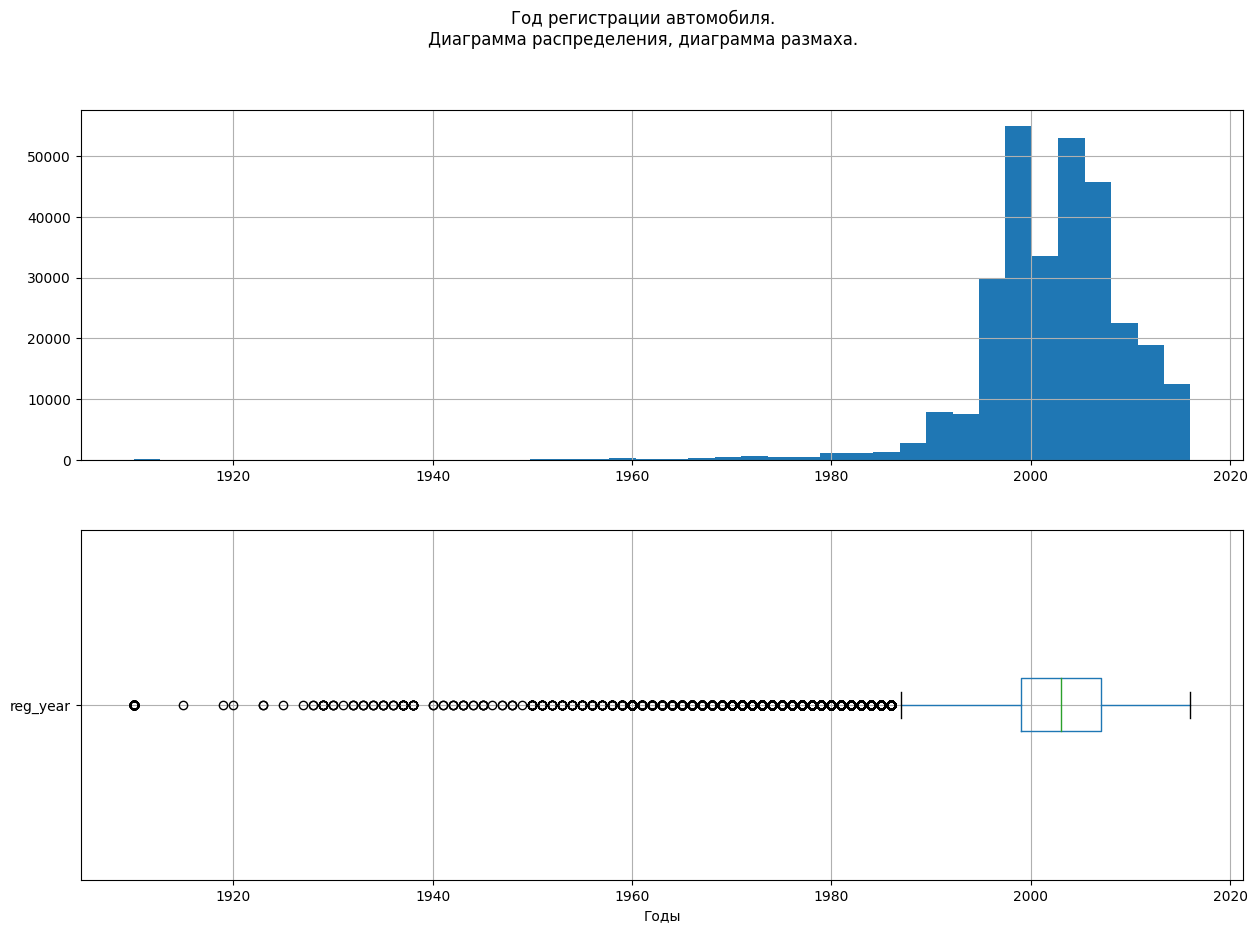

count    295675.000000
mean       2002.504003
std           7.248665
min        1910.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: reg_year, dtype: float64


In [32]:
plot_hist_boxplot(df=df, 
                  column='reg_year',
                  title='Год регистрации автомобиля.\n\
Диаграмма распределения, диаграмма размаха.',
                  xlabel='Годы',
                  bins=[40])

**Вывод:**

- Распределение близко к нормальному. Среднее значение близко к медиане - 2003 год.
- Присутствуют выбросы вниз с минимальным значением 1910 год, максимальное значение - 2016 год.

### Тип коробки передач

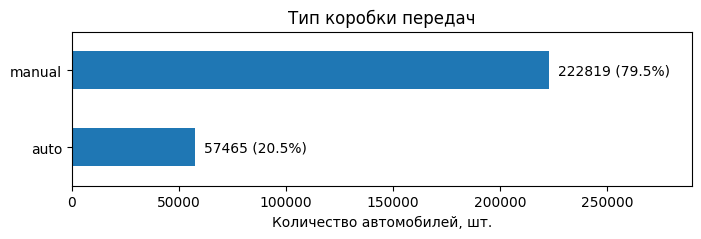

In [33]:
data = df['gearbox'].value_counts().sort_values()
df_vehicle_type = barh(data=data, size_x=8, size_y=2,
          title='Тип коробки передач',
          xlabel="Количество автомобилей, шт.",
          ylabel="")

**Вывод:**

- В выборке представлены преимущественно автомобили с ручной коробкой передач.

### Мощность

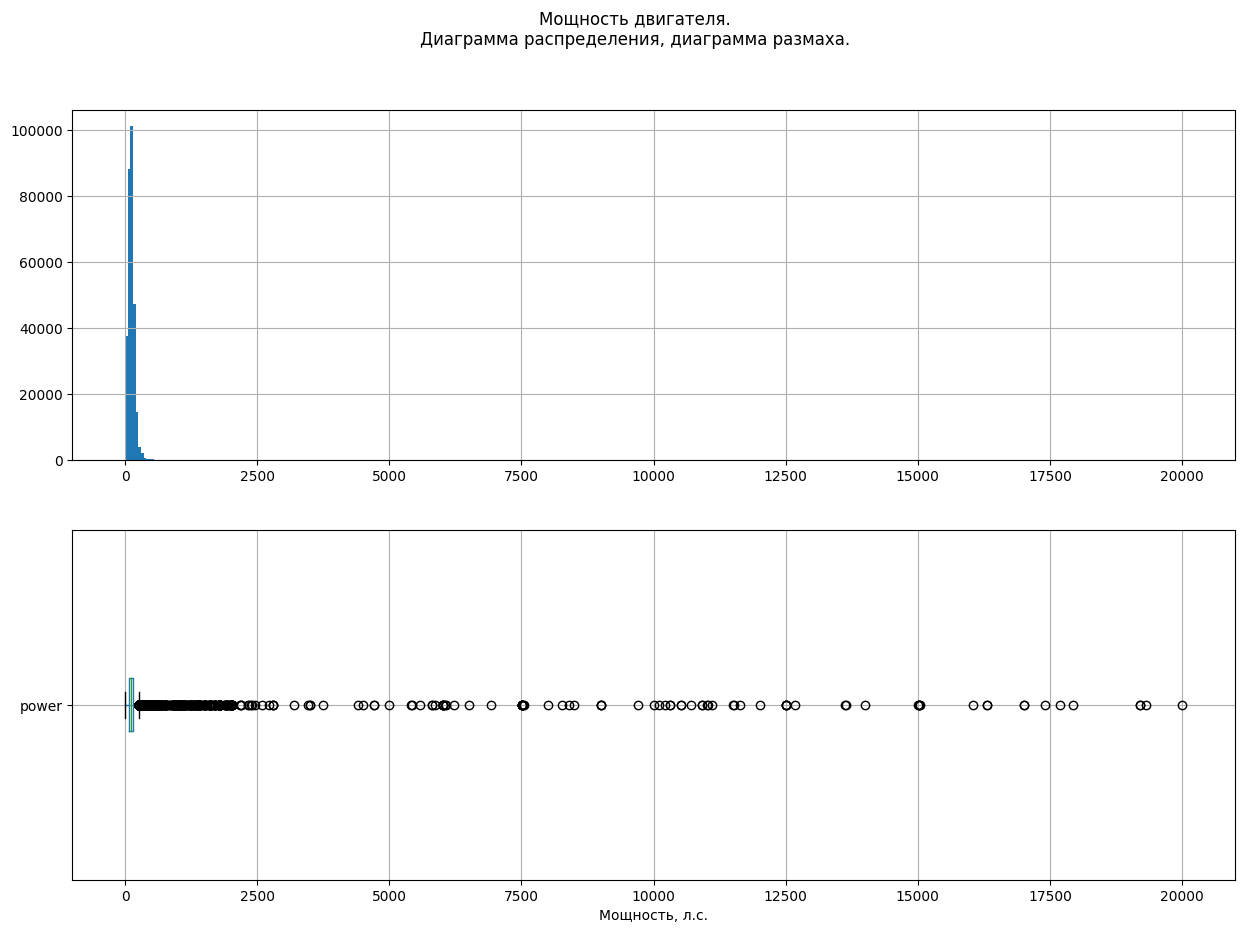

count    295675.000000
mean        111.972865
std         198.013587
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64


In [34]:
plot_hist_boxplot(df=df, 
                  column='power',
                  title='Мощность двигателя.\n\
Диаграмма распределения, диаграмма размаха.',
                  xlabel='Мощность, л.с.',
                  bins=[400])

На графике обнаружены многочисленные выбросы и нулевые значения. Данные значения являются аномальными, поэтому удалим их. 

Изучим гистограмму в районе нулевых значений.

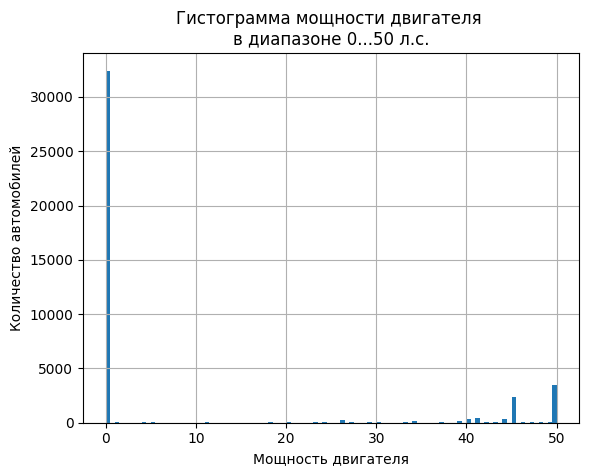

In [35]:
df.plot(kind='hist', y='power', range=(0, 50), bins=100, grid=True, legend=False)
plt.title(f'Гистограмма мощности двигателя \nв диапазоне 0...50 л.с.')
plt.xlabel('Мощность двигателя')
plt.ylabel('Количество автомобилей')
plt.show()

In [36]:
# удаляем строки со значением мощности ниже 15 л.с.
df = df[df['power']>= 15]

In [37]:
# функция для удаления выбросов
# удалим строки с выбросами и перезапишем датафрейм
# http://www.itl.nist.gov/div898/handbook/prc/section1/prc16.htm
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 # межквартильный размах
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [38]:
# применим функцию и удалим выбросы
df = remove_outlier(df,'power')

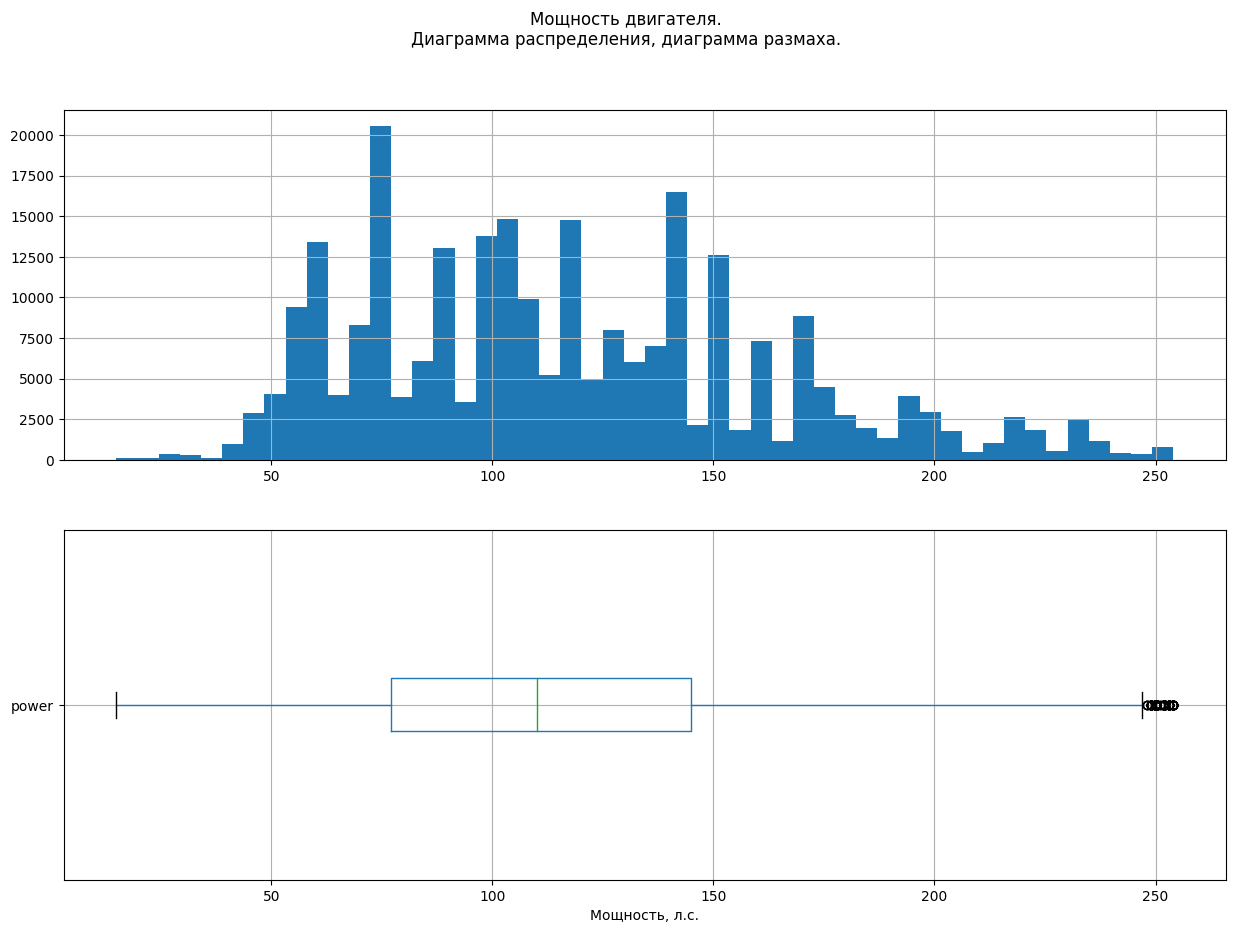

count    256488.000000
mean        117.034345
std          45.718731
min          15.000000
25%          77.000000
50%         110.000000
75%         145.000000
max         254.000000
Name: power, dtype: float64


In [39]:
plot_hist_boxplot(df=df, 
                  column='power',
                  title='Мощность двигателя.\n\
Диаграмма распределения, диаграмма размаха.',
                  xlabel='Мощность, л.с.',
                  bins=[50])

**Вывод:** 
- Аномальные значения удалены. График не имеет нормальное распределение, это можно объяснить тем, что автопроизводители могут подстраивать мощность двигателей под действующие законы и пороги в налоговом законодательстве.
- Мощность двигателя находится в диапазоне от 15 до 254 л.с. с медианой 110 л.с.

### Модель автомобиля

In [40]:
# выведем ТОП-10 моделей выборки
df['model'].value_counts().sort_values(ascending=False).head(10)

golf        20194
3er         14664
polo         8685
astra        7967
corsa        7835
a4           7467
passat       7335
c_klasse     6257
5er          5651
e_klasse     4930
Name: model, dtype: int64

In [41]:
# вычислим общее число моделей
len(df['model'].unique())

247

**Вывод:**

- Всего в выборке 247 моделей, самая популярная из которых `"golf"`.

### Пробег

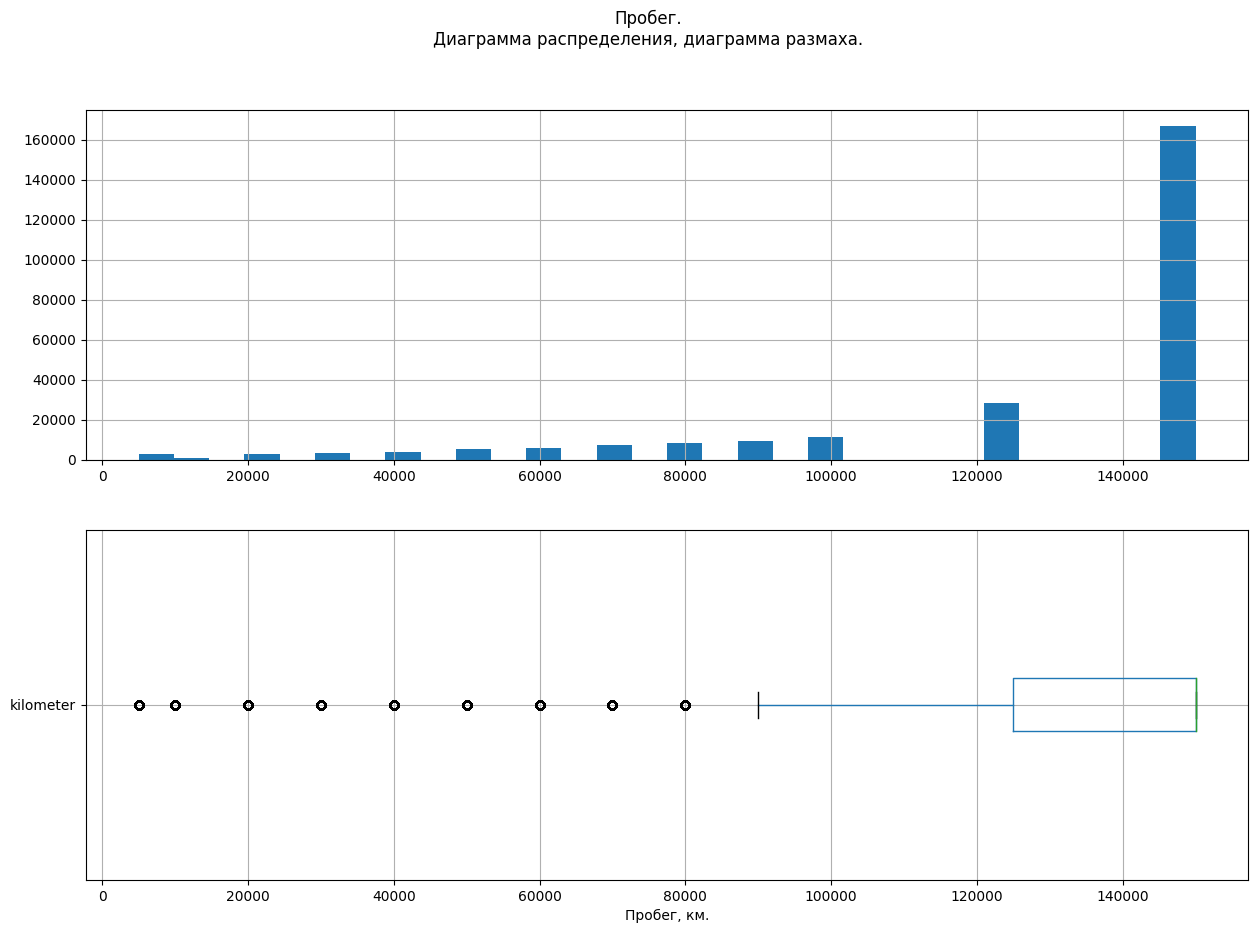

count    256488.000000
mean     127232.599576
std       37550.604762
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64


In [42]:
plot_hist_boxplot(df=df, 
                  column='kilometer',
                  title='Пробег.\n\
Диаграмма распределения, диаграмма размаха.',
                  xlabel='Пробег, км.',
                  bins=[30])

**Вывод:**

- В выборке находятся машины, преимущественно с пробегом 150 тыс. км.

### Тип топлива

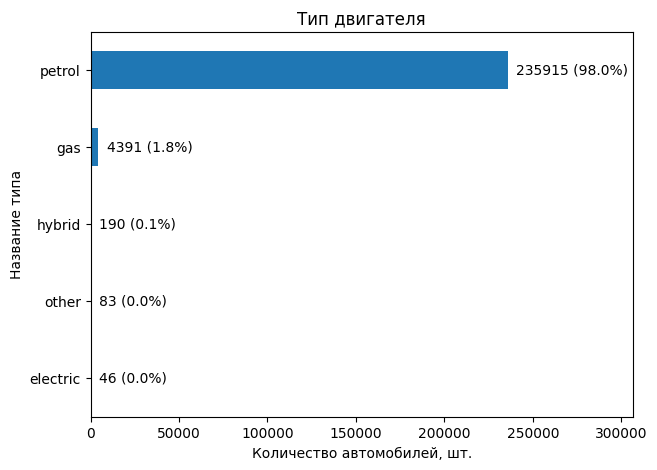

In [43]:
data = df['fuel_type'].value_counts().sort_values()
df_vehicle_type = barh(data=data, size_x=7, size_y=5,
          title="Тип двигателя",
          xlabel="Количество автомобилей, шт.",
          ylabel="Название типа")

**Вывод:**

- В выборке находятся машины, преимущественно с бензиновым двигателем.

### Марка автомобиля

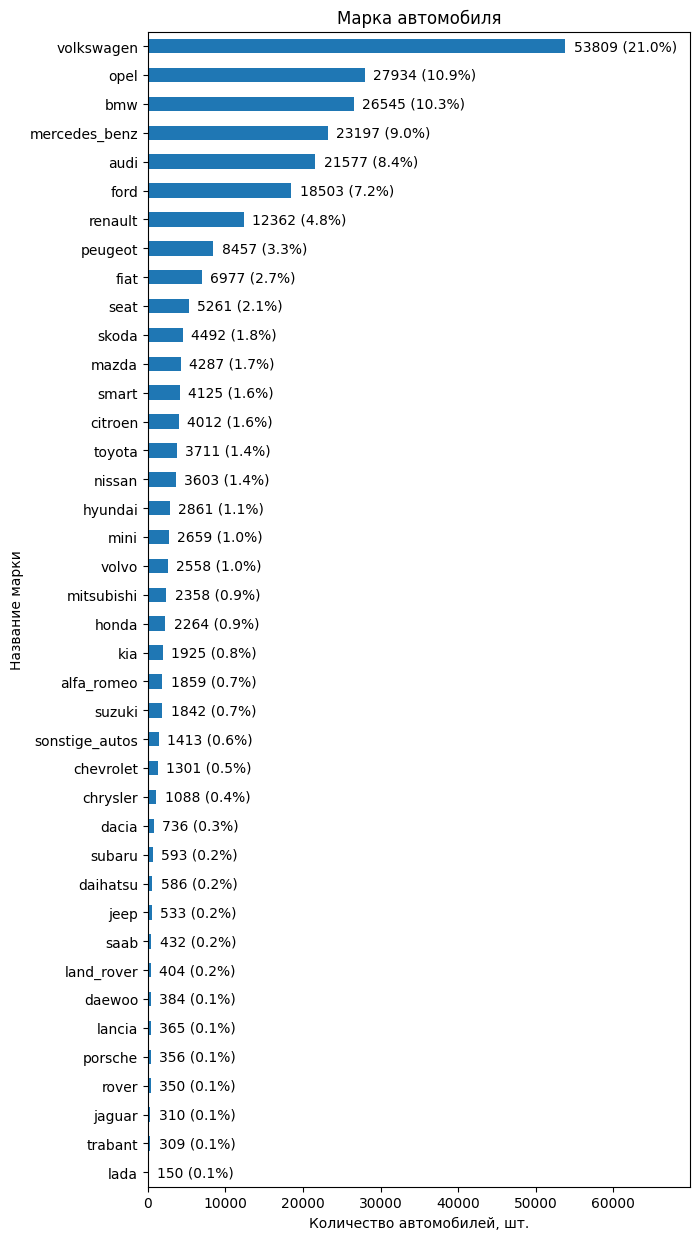

In [44]:
data = df['brand'].value_counts().sort_values()
df_vehicle_type = barh(data=data, size_x=7, size_y=15,
          title="Марка автомобиля",
          xlabel="Количество автомобилей, шт.",
          ylabel="Название марки")

**Вывод:**

- Наибольшую долю в выборке занимают автомобили марки `Volkswagen`.

### Была машина в ремонте или нет

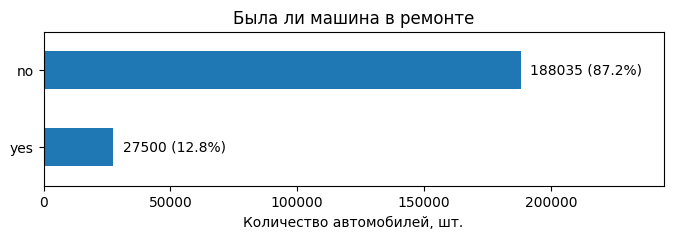

In [45]:
data = df['repaired'].value_counts().sort_values()
df_vehicle_type = barh(data=data, size_x=8, size_y=2,
          title='Была ли машина в ремонте',
          xlabel="Количество автомобилей, шт.",
          ylabel="")

**Вывод:**

- Большая часть автомобилей не была в ремонте.

### Цена

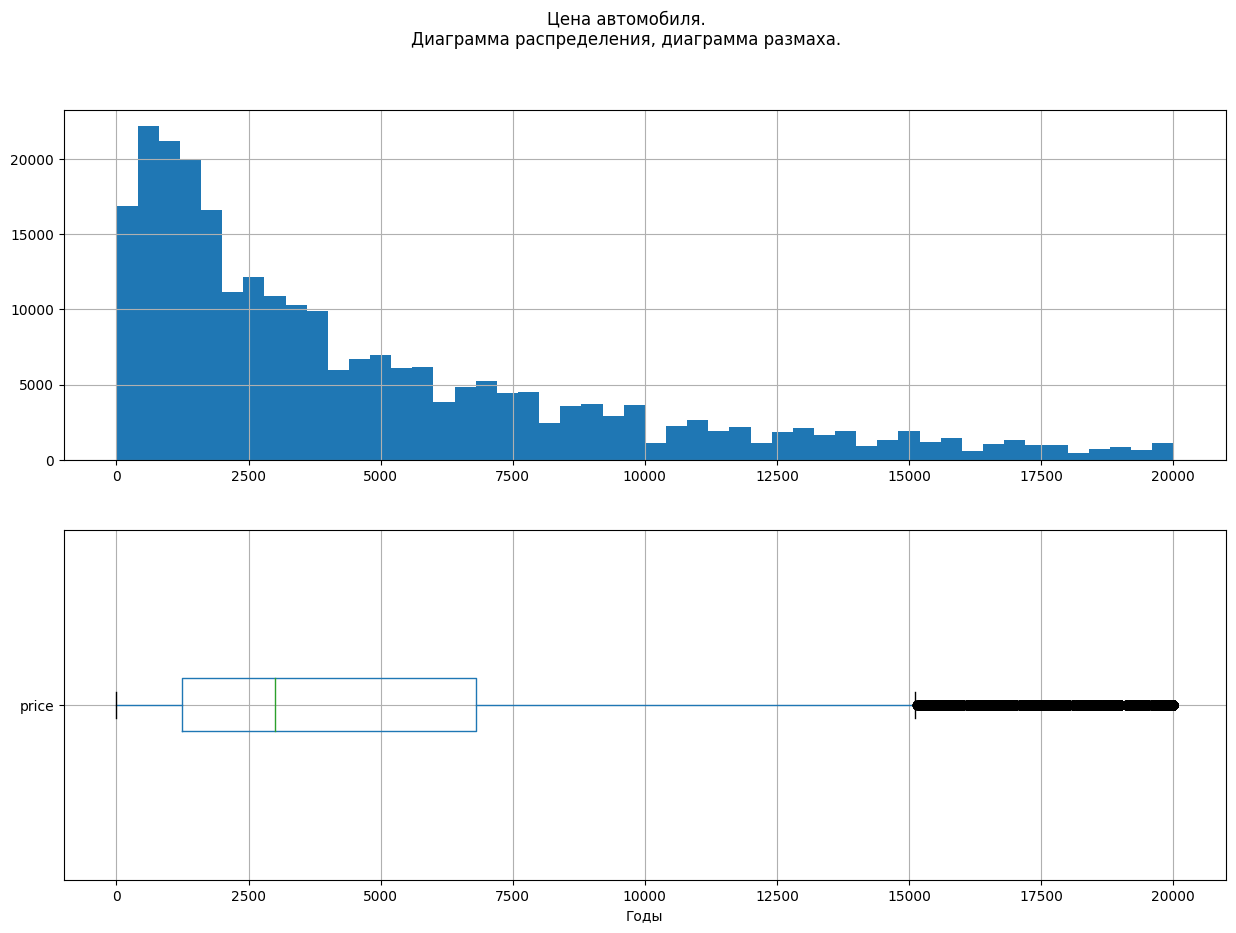

count    256488.000000
mean       4693.014960
std        4546.630056
min           0.000000
25%        1250.000000
50%        3000.000000
75%        6800.000000
max       20000.000000
Name: price, dtype: float64


In [46]:
plot_hist_boxplot(df=df, 
                  column='price',
                  title='Цена автомобиля.\n\
Диаграмма распределения, диаграмма размаха.',
                  xlabel='Годы',
                  bins=[50])

Цена автомобилей в выборке не имеет нормального распределения. Часть цен лежит в районе нуля, чего быть не может. Изучим интервал цен в раоне нуля более подробно.  

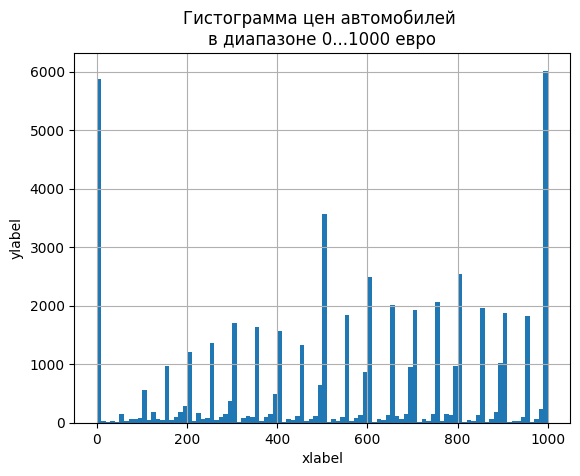

In [47]:
df.plot(kind='hist', y='price', range=(0, 1000), bins=100, grid=True, legend=False)
plt.title(f'Гистограмма цен автомобилей \nв диапазоне 0...1000 евро')
plt.xlabel('xlabel')
plt.ylabel('ylabel')
plt.show()

Можно представить, что кто-то и в правду готов отдать свой старый и сломанный автомобиль бесплатно "в хорошие руки", но это скорее исключение. 

Нулевые цены негативно повлияют на работу модели, поэтому удалим все строки, где цена автомобиля меньше 500 евро. 

In [48]:
# оставляем в датафрейме только те записи, где цены не >= 500 евро.
df = df.loc[~(df['price'] < 500)]

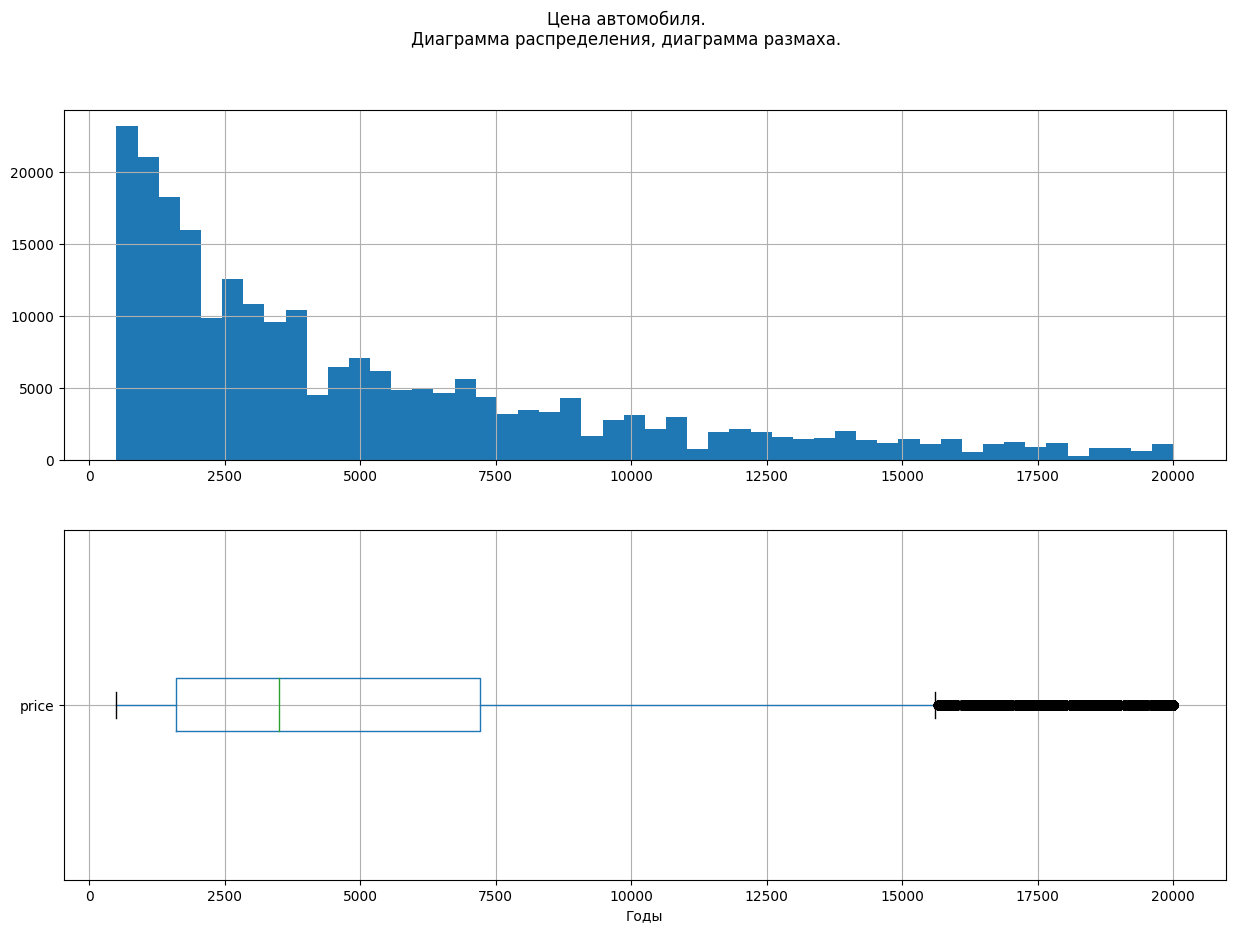

count    235671.000000
mean       5088.605565
std        4535.108472
min         500.000000
25%        1599.000000
50%        3500.000000
75%        7200.000000
max       20000.000000
Name: price, dtype: float64


In [49]:
# выведем обновлённые графики
plot_hist_boxplot(df=df, 
                  column='price',
                  title='Цена автомобиля.\n\
Диаграмма распределения, диаграмма размаха.',
                  xlabel='Годы',
                  bins=[50])

**Вывод:**

- Цена автомобилей в обработанной выборке лежит в диапазоне от 500 евро до 20 тыс. евро с медианой 3,5 тыс. евро. 

## Обработка пропусков

In [50]:
# выведем процент пропусков в столбцах
pd.DataFrame({'Процент пропусков': (df.isna().mean()*100).sort_values(ascending=False)})\
.style.background_gradient('coolwarm')

,Процент пропусков
repaired,14.153205
model,10.963589
fuel_type,5.129184
vehicle_type,3.374620
gearbox,1.813969
price,0.000000
reg_year,0.000000
power,0.000000
kilometer,0.000000
brand,0.000000


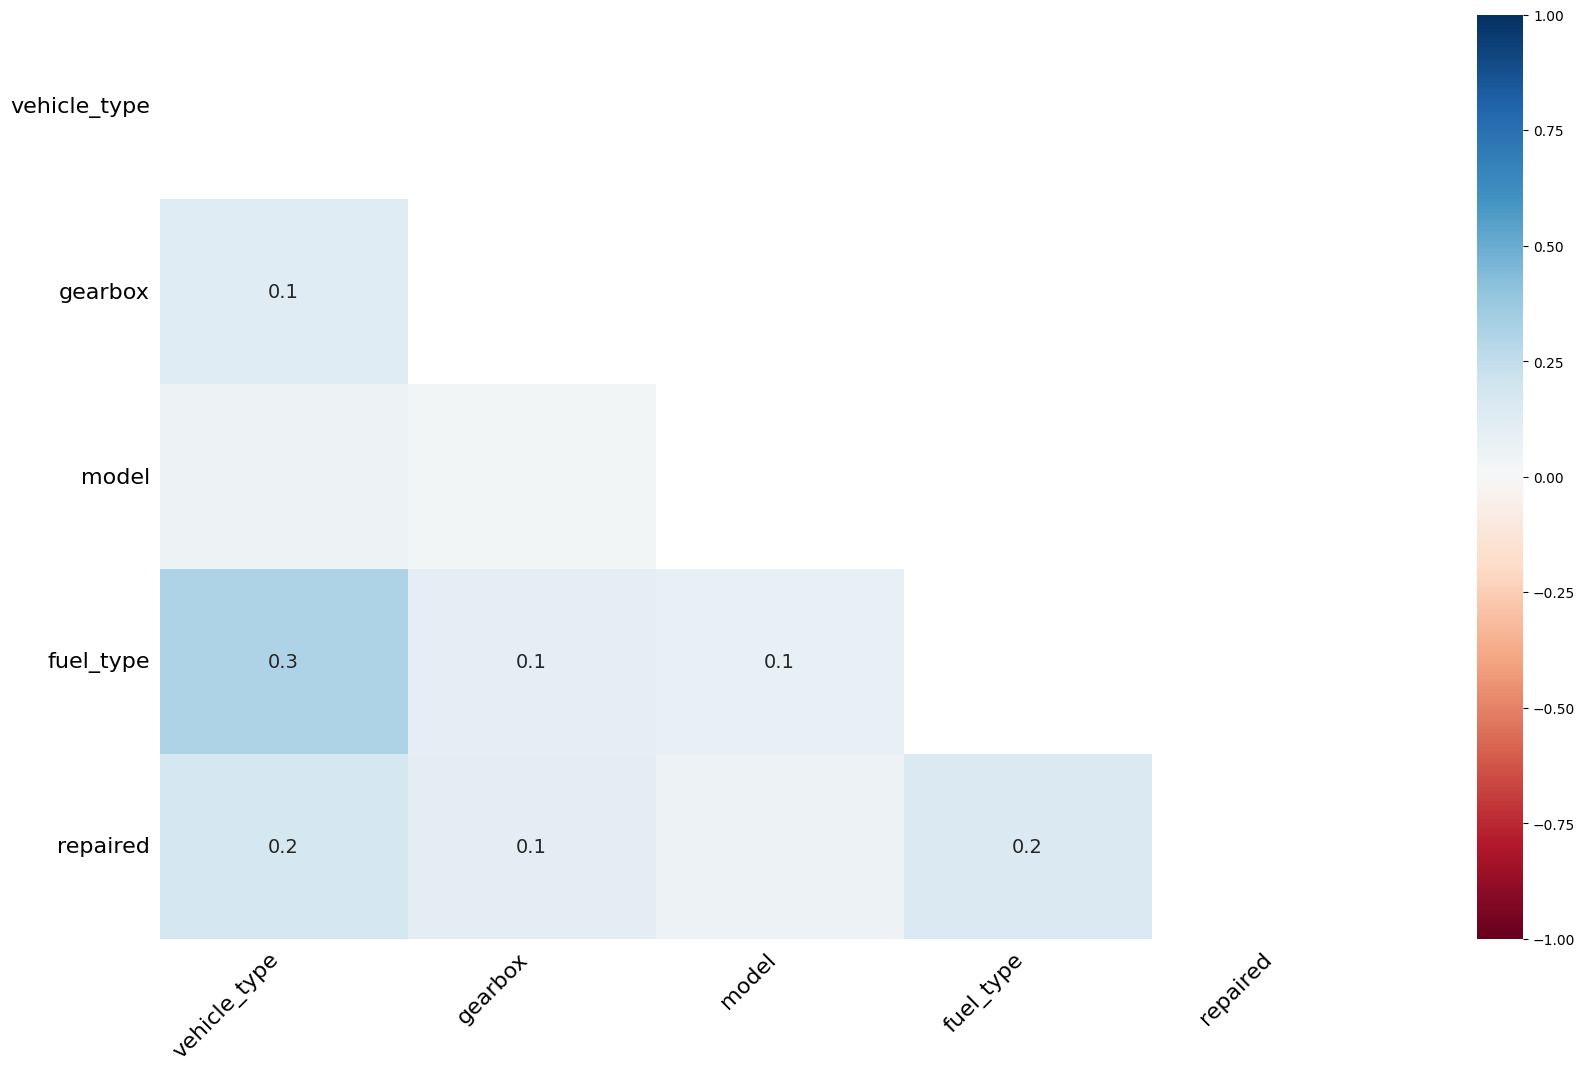

In [51]:
# используем модуль missingno для анализа корреляции пропусков
msno.heatmap(df)
plt.show()

**Вывод:**

Наибольшее число пропусков в столбце `repaired`. Высокой корреляции пропущенных значений не наблюдается, это означает, что удаление пропусков из каждого столбца будет уменьшать количество строк в выборке.

Обработаем пропуски в пайплайне.

## Корреляционный анализ

Построим матрицу корреляции признаков с помощью библиотеки `phik`.

In [52]:
# создаём список с наименованиями непрерывных признаков
interval_cols = ['power'] 

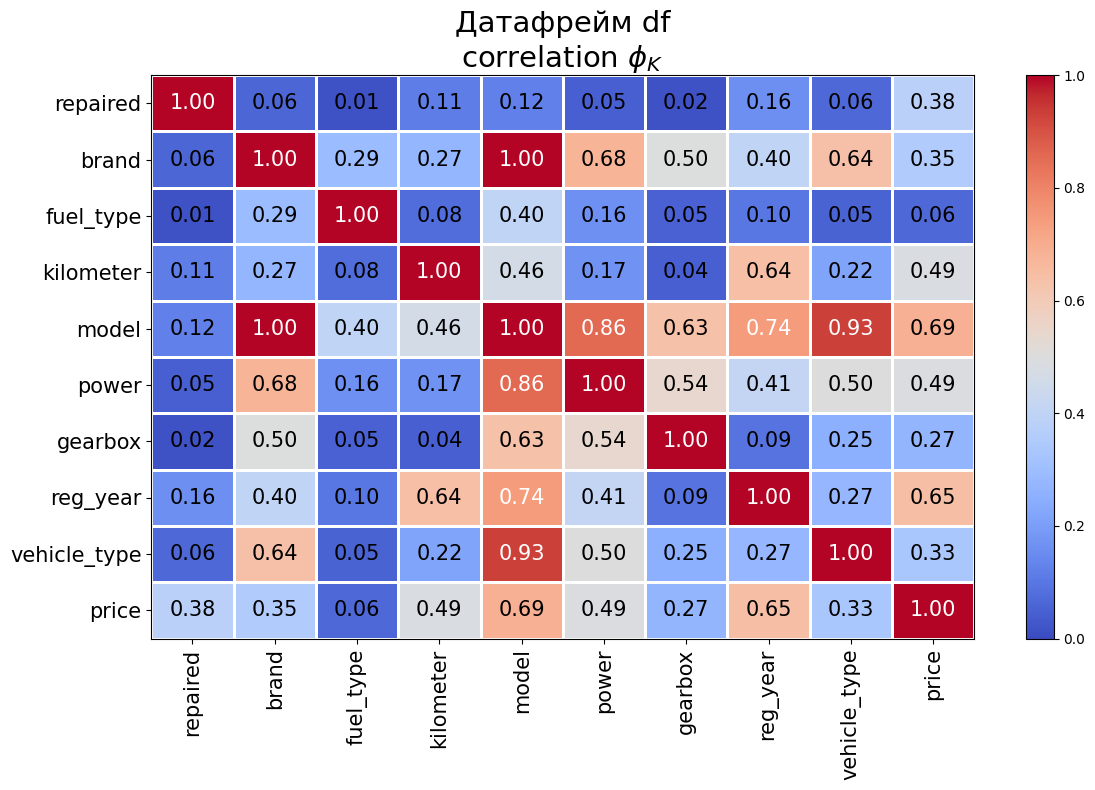

In [53]:
# считаем корреляции df
phik_overview = phik_matrix(df, interval_cols=interval_cols) 

# строим матрицу
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='coolwarm',
    title=f'Датафрейм df\ncorrelation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(12, 8))
plt.show()

**Вывод:**

Видим очень высокую корреляцию между следующими признаками:
- `марка` и `модель`;
- `марка` и `мощность`;
- `модель` и `мощность`;
- `модель` и `тип двигателя`.

Не смотря на высокую корреляцию ни один из признаков не будем удалять. Можем представить вполне ожидаемую ситуацию, когда выйдет новая марка мерседеса, на которой модель не обучалась. Но модель "будет знать", что мерседес с электрическим двигателем мощностью 200 л.с. может стоить примерно *n* евро. Поэтому все признаки важны.

## Подготовка данных и обучение моделей

Обучим три модели: 
  1. Модель линейной регрессии LinearRegression;
  2. Модель градиентного бустинга LightGBM;
  3. Модель дерева решений DecisionTree.

- Целевой признак: `price`.
- Разобьём данные на обучающую и тестовую выборки в соотношении 75:25.
- Для выбора лучшей модели будем считать метрику RMSE. Значение метрики RMSE должно быть меньше 2500.

In [54]:
## делим данные на тренировочные и тестовые----------------------------------
X = df.drop('price', axis=1) # входные признаки
y = df['price']  

# разделим данные на тренировочные и тестовые, зафиксируем random_state
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE,
    test_size=TEST_SIZE)
    
X_train.shape, X_test.shape

((176753, 9), (58918, 9))

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 235671 entries, 1 to 309328
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   price         235671 non-null  int64 
 1   vehicle_type  227718 non-null  object
 2   reg_year      235671 non-null  int64 
 3   gearbox       231396 non-null  object
 4   power         235671 non-null  int64 
 5   model         209833 non-null  object
 6   kilometer     235671 non-null  int64 
 7   fuel_type     223583 non-null  object
 8   brand         235671 non-null  object
 9   repaired      202316 non-null  object
dtypes: int64(4), object(6)
memory usage: 19.8+ MB


In [56]:
# создаём списки с названиями признаков

# категориальные номинальные признаки
# для более эффективного обучения модели бустинга вместо OneHotEncoder() 
# будем использовать OrdinalEncoder() 
# в линейной модели будем использовать OneHotEncoder().
cat_columns = ['vehicle_type', 
               'gearbox', 
               'model', 
               'fuel_type', 
               'brand', 
               'repaired',
               'kilometer',
               'reg_year']

# количественные признаки
num_columns = ['power']

In [57]:
## создаем пайплайны---------------------------------------------------------
# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE

ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, 
                                                strategy='most_frequent')),
     
     ('ord',  OrdinalEncoder(handle_unknown='use_encoded_value', 
                             unknown_value=np.nan)),
     
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, 
                                               strategy='most_frequent'))
    ]
)

ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

In [58]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('cat', ohe_pipe, cat_columns), 
        ('num', StandardScaler(), num_columns) # масштабируем количественные признаки
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

In [59]:
# перебираем гиперпараметры моделей
param_grid = [


    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__cat': [ohe_pipe, 'passthrough'],
        'preprocessor__num': [StandardScaler(), 'passthrough']

    },
    
    
    # словарь для модели DecisionTreeRegressor() 
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__criterion': ['squared_error'],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__cat': [ord_pipe, 'passthrough'],
        'preprocessor__num': [StandardScaler(), 'passthrough']
    },
    
    
     # словарь для модели LGBMRegressor() 
    {
        'models': [LGBMRegressor(random_state=RANDOM_STATE)],
        'models__boosting_type': ['gbdt', 
                                  'dart'],
        'preprocessor__cat': [ord_pipe, 'passthrough'],
        'preprocessor__num': [StandardScaler(), 'passthrough']
    },
]

In [60]:
# Создаем пустые списки, где будем хранить результаты работы моделей
fit_time, predict_time, rmse_cv, rmse_test, model_params, cv_results = \
[], [], [], [], [], []

for i in range(len(param_grid)):
    model = RandomizedSearchCV(
        pipe_final, 
        param_grid[i],
        cv=3,
        scoring='neg_mean_squared_error',
        random_state=RANDOM_STATE,
        n_jobs=-1)
    
    # замеряем время обучения
    start = time()
    model.fit(X_train, y_train)
    end = time()
    fit_time.append(round(((end-start)/60),3)) # переводим в минуты
    
    # замеряем RMSE на кросс-валидации
    rmse_cv.append(round(sqrt(abs(model.best_score_))))
    
    # получаем лучшую модель из best_estimator
    best_model = model.best_estimator_
    model_params.append(best_model)
    
    # замеряем время предсказания
    start = time()
    best_model.predict(X_train)
    end = time()
    predict_time.append(round(((end-start)/60),3)) # переводим в минуты
    
    # расчет прогноза на тестовых данных
    y_test_pred = best_model.predict(X_test)
    rmse_test.append(round(mean_squared_error(y_test, y_test_pred, squared=False)))
    
    # сохраняем результаты работы моделей
    cv_results.append(model.cv_results_)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007188 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 624
[LightGBM] [Info] Number of data points in the train set: 176753, number of used features: 9
[LightGBM] [Info] Start training from score 5095.597710


## Анализ моделей

Сравним результаты работы моделей. Для удобства сведём их в таблицу.

In [61]:
# выбираем параметры лучшей модели из словаря результатов кросвалидации
# и сохраняем в новый список
cv_results_params = []
for i in cv_results:
    cv_results_params.append(i.get('params')[0])

# отображаем всё содержимое ячеек    
pd.set_option('display.max_colwidth', None)

table = pd.DataFrame({
    'Время обучения': fit_time,
    'Время предсказания': predict_time,
    'RMSE на кросс-валидации': rmse_cv,
    'RMSE на тестовой выборке': rmse_test,
    'Параметры лучшей модели': cv_results_params},
    index = ['LinearRegression', 'DecisionTreeRegressor', 'LGBMRegressor'])
table

,Время обучения,Время предсказания,RMSE на кросс-валидации,RMSE на тестовой выборке,Параметры лучшей модели
LinearRegression,0.599,0.021,2031,2023,"{'preprocessor__num': StandardScaler(), 'preprocessor__cat': (SimpleImputer(strategy='most_frequent'), OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)), 'models': LinearRegression()}"
DecisionTreeRegressor,0.119,0.009,2904,2905,"{'preprocessor__num': 'passthrough', 'preprocessor__cat': 'passthrough', 'models__max_features': 4, 'models__max_depth': 4, 'models__criterion': 'squared_error', 'models': DecisionTreeRegressor(random_state=42)}"
LGBMRegressor,0.355,0.016,1668,1663,"{'preprocessor__num': StandardScaler(), 'preprocessor__cat': (SimpleImputer(strategy='most_frequent'), OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=nan), SimpleImputer(strategy='most_frequent')), 'models__boosting_type': 'gbdt', 'models': LGBMRegressor(random_state=42)}"


Проверим нашу модель на адекватность, сравнив результат с предсказанием модели `DummyRegressor`.

In [62]:
# инициализируем модель DummyRegressor, обучим и получим прогноз
dummy_сlass = DummyRegressor(strategy="mean")
dummy_сlass.fit(X_train, y_train)
dummy_preds = dummy_сlass.predict(X_test)
dummy_rmse = mean_squared_error(y_test, dummy_preds, squared=False)

print(f'RMSE DummyRegressor на тестовой выборке : {round(dummy_rmse)} евро')

RMSE DummyRegressor на тестовой выборке : 4527 евро


Любая из наших моделей (лучшая) показывает лучшие результаты в сравнении с `DummyRegressor` при стратегии `"mean"`.

**Вывод:**

Лучшей моделью оказалась модель градиентного бустинга **LGBMRegressor** с параметрами:

'preprocessor__num': 'passthrough', 'preprocessor__cat': 'passthrough', 'models__max_features': 4, 'models__max_depth': 4, 'models__criterion': 'squared_error', 'models': DecisionTreeRegressor(random_state=42)

Модель LGBMRegressor оказалась точнее линейной модели LinearRegression в прогнозах, при этом время предсказания у моделей схоже. LinearRegression быстрее обучается, и если этот показатель окажется важен, линейная модель может использоваться в качестве альтернативного варианта.

Модель дерева решений DecisionTreeRegressor имеет показатель RMSE > 2500 евро, что не удовлетворяет требованиям заказчика. 

## Выводы

**В ходе проекта мы провели следующую работу:**
- изучили данные, проверили их на предмет аномалий и несоответствий;

- произвели предобработку данных для последующего анализа: проверили их на пропуски и дубликаты, исправили ошибки;

- произвели исследовательский анализ основных показателей: 
  - тип автомобильного кузова;
  - год регистрации автомобиля;
  - тип коробки передач;
  - мощность;
  - модель автомобиля;
  - пробег;
  - тип топлива;
  - марка автомобиля;
  - была ли машина в ремонте;
  - цена.

- Произвели корреляционный анализ признаков.

- подготовили данные и обучили 3 модели для решения задачи регрессии (прогноз стоимости автомобиля):
  - LinearRegression;
  - DecisionTreeRegressor;
  - LGBMRegressor.
  
- произвели анализ результатов работы моделей и выбрали лучшую модель.

**Результаты:**

Лучшей моделью оказалась модель градиентного бустинга **LGBMRegressor**:

- Время обучения:           7.618 мин.
- Время предсказания:       0.032 мин.
- RMSE на тестовой выборке: 1663 евро

Модель LGBMRegressor оказалась точнее линейной модели LinearRegression в прогнозах, при этом время предсказания у моделей схоже. LinearRegression быстрее обучается, и если этот показатель окажется важен, линейная модель может использоваться в качестве альтернативного варианта.

Модель дерева решений DecisionTreeRegressor имеет показатель RMSE > 2500 евро, что не удовлетворяет требованиям заказчика. 

**Рекомендации:**

Для улучшения качества работы модели необходимо повысить качество исходных данных:
- заполнить пропуски реальными значениями;
- заменить значения "other" в столбце "Model" на названия моделей.